*The purpose of this notebook is to train, evaluate, and tune ML regression models for our problem*

### Tested models :

**Baseline dummy regressor** :

- RMSE = 0.4451, std = 0.0158

**Linear regression** :

- RMSE = 0.2217, std = 0.0089
- doing better than baseline. isues : from residuals we see that the model predict wrongly 3 specific range of values between ~ 500 000 and ~ 1M$ cost. not so good either > 1M $ 
- struggle to find linear relationship between explanatory variables and target

**Linear lasso regression** :

- tunned cv param : ```alpha=0.0001```
- RMSE = 0.2216, std = 0.0089
- small score improvments, this regularization didn't solve the issues mentioned above

**Linear ridge regression** :

- tunned cv param : ```alpha=4``` 
- RMSE = 0.2217, std = 0.0089
- no score improvments, this regularization didn't solve the issue mentioned above either

*linear regression models are not conclusive, moving on to regression trees*

**Random forest regressor**

- gridsearch tunned cv params : ```n_estimators= 300, max_depth= 25, min_samples_split= 4, min_samples_leaf= 1```
- RMSE = 0.1590, std = 0.0057
- this time the score improve significantly
- from residual and std scores : small overfiting
- top 3 feature importance : Proposed Units > total_area_m2 > Proposed Use_f (didn't learn anything from Zipcode_f and Permit Type features !)

**XGBoost**

- gridsearch tunned cv params : ```max_depth=10, learning_rate=0.05, n_estimators=250, colsample_bytree=0.9, subsample=0.8```
- RMSE = 0.1586, std = 0.0058
- No noticeable differences in performance with random forest
- top 3 feature importance :  total_area_m2 > Proposed Units > Permit Type

*Conclusion : we sould use the random forest regressor as our final model because it has the best performance, run faster than XGBoost and is simpler to explain*

*Remarks :*

- *Prediction error increase as true target cost value increase*

- *we have choosen to encode with dummy values the categorical features. It might not be the proper encoding as they are nominal but our models behave the same way with one-hot encoding, plus dummy encoding allow us to compute feature importances*

- *from features importance analysis, we see that there is large differences of feature importance between random forest models and XGBoost models -> some features are be correlated with other features like Permit Type and Proposed Units. Sould we remove some of these features ?*







# Setup

Import sklearn tools and data vizualisation libraries

In [22]:
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error,mean_squared_error,mean_squared_log_error,mean_absolute_error,explained_variance_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC

import sys #importing local functions in src folder
sys.path.append('../src/')
from functions import cross_validate_score, score_ML_log

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings('ignore')

sns.set()

# Import Dataset

We use a cleaned version of the original Building Permits dataset : cleaned NaN, cleaned outliers, added 'building ground surface area' feature, feature engineering

In [23]:
dataset_url = 'https://drive.google.com/file/d/1Ffbhy12m4JG9REEdSQwwewIFE0KUiEX3/view?usp=sharing'
dataset_url ='https://drive.google.com/uc?id=' + dataset_url.split('/')[-2]

dataset = pd.read_csv(dataset_url)

In [24]:
dataset.shape

(6575, 62)

In [25]:
dataset.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Name,Street Suffix,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Number of Proposed Stories,Permit Expiration Date,Estimated Cost,Revised Cost,Proposed Use,Proposed Units,Plansets,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID,address,lat,lon,Duration_construction_days,Process_time_days,Year,Est_Cost_Infl,Rev_Cost_Infl,Est_Cost_Infl_log10,Est_Cost_Infl_loge,lat_lon,address.1,geometry,point,polygon,area_m2,Number of Proposed Stories_,Number of Proposed Stories_cat,Zipcode_,Proposed Construction Type_,Number of Proposed Stories_cat_f,Proposed Use_f,Proposed Construction Type_f,Number of Proposed Stories_bct,Number of Proposed Stories_cat_f_bct,Proposed Construction Type_f_bct,Proposed Units_bct,Proposed Use_f_bct,Duration_construction_days_bct,total_area_m2,cost_per_m2
0,9111378,2,new construction wood frame,1991-06-28,3566,037,3686,17th,St,erect a four story three unit residential bldg,complete,1993-09-20,1991-06-28,1992-11-30,1993-09-20,NaN,4.0,1994-11-30,250000.0,350000.0,apartments,3.0,2.0,5,wood frame (5),NaN,8.0,Castro/Upper Market,94114,POINT (-122.42798037718552 37.76316610254898),342335281878,3686 17th St,-122.427980,37.763166,294.0,521.0,1991,4.973752e+05,696325.256975,5.696684,13.117100,-4623.268159,"3686 17th St, San Francisco, CA 94114",NaN,POINT (-122.42798037718552 37.76316610254898),"POLYGON ((6004384.44156398 2106033.407080037, ...",147.915331,4.0,3-4 stories,94114,5,0,0,0,1.746189,0.0,0.0,1.486984,0.000000,7.659654,591.661324,840.641704
1,8707430,2,new construction wood frame,1987-05-29,1733,046,1254,18th,Av,NaN,complete,1988-10-07,1987-05-29,1988-01-20,1988-10-07,NaN,3.0,1990-01-20,394000.0,NaN,apartments,4.0,2.0,5,wood frame (5),NaN,4.0,Inner Sunset,94122,POINT (-122.47578567375196 37.76447248121622),161612112132,1254 18th Av,-122.475786,37.764472,261.0,236.0,1987,9.398079e+05,NaN,5.973039,13.753431,-4625.233438,"1254 18th Av, San Francisco, CA 94122","{""type"": ""Polygon"", ""coordinates"": [[[-122.476...",POINT (-122.47578567375196 37.76447248121622),"POLYGON ((5990594.490913103 2106871.242348627,...",253.922359,3.0,3-4 stories,94122,5,0,0,0,1.486984,0.0,0.0,1.746189,0.000000,7.451394,761.767077,1233.720846
2,7912377,2,new construction wood frame,1979-12-01,1361,064,3900,California,St,NaN,complete,1984-02-29,1979-12-01,1983-01-24,1984-02-29,NaN,3.0,1985-01-24,790000.0,NaN,apartments,8.0,2.0,5,wood frame (5),NaN,2.0,Inner Richmond,94118,POINT (-122.45952470081986 37.7858592269433),86903496726,3900 California St,-122.459525,37.785859,401.0,1150.0,1979,2.948572e+06,NaN,6.469612,14.896831,-4627.238361,"3900 California St, San Francisco, CA 94118","{""type"": ""Polygon"", ""coordinates"": [[[-122.459...",POINT (-122.45952470081986 37.7858592269433),POLYGON ((5995398.966155565 2114500.1454920806...,504.669823,3.0,3-4 stories,94118,5,0,0,0,1.486984,0.0,0.0,2.457309,0.000000,8.214724,1514.009469,1947.525221
3,8010466,2,new construction wood frame,1980-11-25,4159,074,1084,De Haro,St,NaN,complete,1985-07-05,1980-11-25,1984-08-06,1985-07-05,NaN,3.0,1985-08-06,210500.0,NaN,2 family dwelling,2.0,4.0,5,wood frame (5),NaN,10.0,Potrero Hill,94107,POINT (-122.40107686660524 37.7560791545319),1490171598,1084 De Haro St,-122.401077,37.756079,333.0,1350.0,1980,6.922231e+05,NaN,5.840246,13.447664,-4621.384747,"1084 De Haro St, San Francisco, CA 94107",NaN,POINT (-122.40107686660524 37.7560791545319),POLYGON ((6012157.402672291 2103366.9430118585...,167.842843,3.0,3-4 stories,94107,5,0,1,0,1.486984,0.0,0.0,1.161232,0.717735,7.880294,503.528529,1374.744586
4,8010466,2,new construction wood frame,1980-11-25,4159,073,1082,De Haro,St,NaN,complete,1985-07-05,1980-11-25,1984-08-06,1985-07-05,NaN,3.0,1985-08-06,210500.0,NaN,2 family dwelling,2.0,4.0,5,

In [26]:
dataset.columns

Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number', 'Street Name',
       'Street Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Number of Proposed Stories',
       'Permit Expiration Date', 'Estimated Cost', 'Revised Cost',
       'Proposed Use', 'Proposed Units', 'Plansets',
       'Proposed Construction Type', 'Proposed Construction Type Description',
       'Site Permit', 'Supervisor District',
       'Neighborhoods - Analysis Boundaries', 'Zipcode', 'Location',
       'Record ID', 'address', 'lat', 'lon', 'Duration_construction_days',
       'Process_time_days', 'Year', 'Est_Cost_Infl', 'Rev_Cost_Infl',
       'Est_Cost_Infl_log10', 'Est_Cost_Infl_loge', 'lat_lon', 'address.1',
       'geometry', 'point', 'polygon', 'area_m2',
       'Number of Proposed Stories_', 'Number of Proposed Stories

In [27]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6575 entries, 0 to 6574
Data columns (total 62 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Permit Number                           6575 non-null   object 
 1   Permit Type                             6575 non-null   int64  
 2   Permit Type Definition                  6575 non-null   object 
 3   Permit Creation Date                    6575 non-null   object 
 4   Block                                   6575 non-null   object 
 5   Lot                                     6575 non-null   object 
 6   Street Number                           6575 non-null   int64  
 7   Street Name                             6575 non-null   object 
 8   Street Suffix                           6575 non-null   object 
 9   Description                             5587 non-null   object 
 10  Current Status                          6575 non-null   obje

# Feature Selection

Features are selected manually based on their relevance and/or strong correlation with the target. We end up with 4 numeric features and 3 categorical features

<AxesSubplot:>

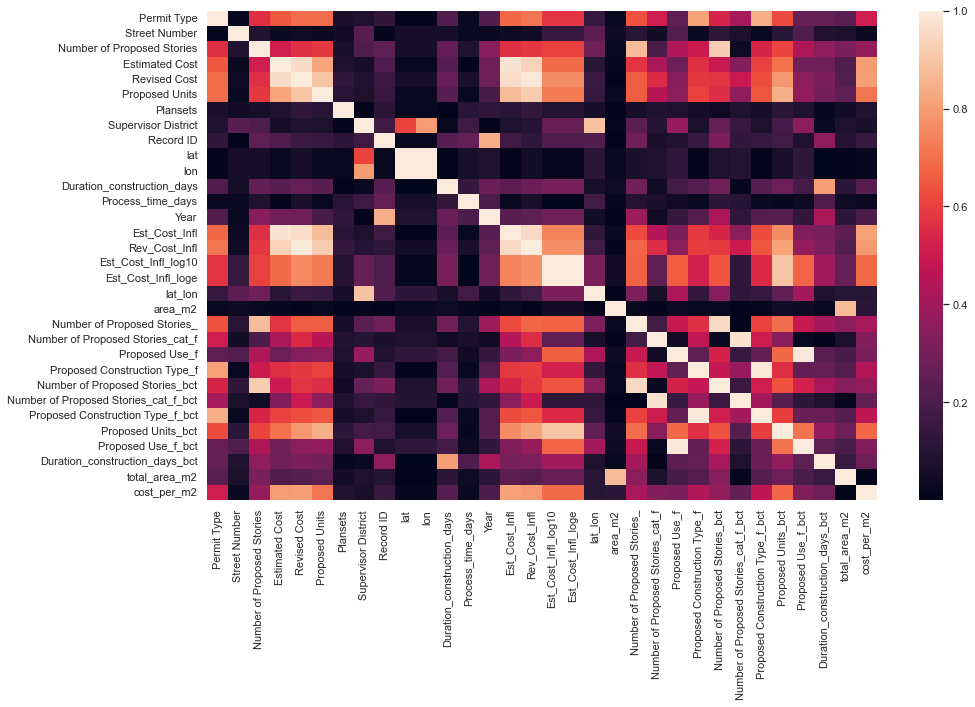

In [28]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(dataset.corr(method='pearson').abs(), annot=False, ax=ax)

### Target Info

- **Est_Cost_Infl_log10** : estimated construction cost of a building taking inflation into account and converted into log10

### Feature Info

- **Permit Type** : type of permit
- **Proposed Units** : number of units built
- **Number of Proposed Stories_**: number of stories built
- **Proposed Use** : type of use
- **Proposed Construction Type_** : fire resistance rating (building structure)
- **lat_lon** : coordinates of the building (latitude * longitude)
- **total_area_m2** : building ground surface area * number of stories
- **Zipcode** : zipcode to which the building belong


In [29]:
dataset['Zipcode_f'] = dataset['Zipcode_'].replace('Other', 94000).astype(int)

In [58]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list =[
    'Permit Type',
    'Proposed Units',
    'Number of Proposed Stories_',
    'Proposed Use_f',
    'Proposed Construction Type_f',
    #'Proposed Use',
    #'Proposed Construction Type_',
    'lat_lon',
    'total_area_m2',
    #'Zipcode'
    'Zipcode_f'
    ]

target_variable = "Est_Cost_Infl_log10"

X = dataset.loc[:,features_list]
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    5.696684
1    5.973039
2    6.469612
3    5.840246
4    5.840246
Name: Est_Cost_Infl_log10, dtype: float64

X :
   Permit Type  Proposed Units  Number of Proposed Stories_  Proposed Use_f  \
0            2             3.0                          4.0               0   
1            2             4.0                          3.0               0   
2            2             8.0                          3.0               0   
3            2             2.0                          3.0               1   
4            2             2.0                          3.0               1   

   Proposed Construction Type_f      lat_lon  total_area_m2  Zipcode_f  
0                             0 -4623.268159     591.661324      94114  
1                             0 -4625.233438     761.767077      94122  
2                             0 -4627.238361    1514.009469      94118  
3                             0 -4621.384747     503.528529      9

In [59]:
#Manually selecting type of features
numeric_features=[
    'Permit Type',
    'Proposed Units',
    'Number of Proposed Stories_',
    'lat_lon',
    'total_area_m2',
    'Zipcode_f',
    'Proposed Use_f',
    'Proposed Construction Type_f'
    ]

categorical_features=[
    #'Zipcode',
    #'Proposed Use',
    #'Proposed Construction Type_'
    ] 

## **Preprocessor**

- Numeric features : standardizing, scaling, replacing remaining missing values by columns' mean

- Categorical features : one hot encoding as they are nominals

In [60]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## **Defining training/test sets**

Using the train_test_split function, we separate our dataset regarding 80% training data and 20% test data

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

print("Preprocessing X_train...")
print()
X_train = preprocessor.fit_transform(X_train)
print("...Done!")
print(X_train[0:5,:]) # X_train is now a numpy array
print()

# Test pipeline
print("Preprocessing X_test...")
print()
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print("...Done!")
print(X_test[0:5,:]) # X_test is now a numpy array
print()

#Y_train = Y_train.to_numpy()
#Y_test = Y_test.to_numpy()

Preprocessing X_train...

...Done!
[[ 0.21625487 -0.29038835 -0.84520684  0.93761135 -0.46635782 -0.4430332
   1.08147374 -0.21058111]
 [ 0.21625487 -0.24227082 -0.02819168 -0.69856192 -0.07607803  0.2827757
  -0.08230528 -0.21058111]
 [ 0.21625487  0.09455185  0.78882348 -1.63461302 -0.43950711  0.21019481
  -1.2460843  -0.21058111]
 [ 0.21625487 -0.29038835 -0.84520684  1.03033759 -0.63465029 -0.4430332
   1.08147374 -0.21058111]
 [ 0.21625487 -0.29038835 -0.02819168  0.27604726  0.09656771  0.93600371
   1.08147374 -0.21058111]]

Preprocessing X_test...

...Done!
[[ 0.21625487 -0.29038835 -0.02819168  1.44836085 -0.54837014  0.42793748
   1.08147374 -0.21058111]
 [ 0.21625487 -0.24227082 -0.02819168 -0.87929061 -0.36044652 -1.16884211
  -0.08230528 -0.21058111]
 [ 0.21625487 -0.04980072  0.78882348  0.08465614  0.20907926  0.93600371
  -1.2460843  -0.21058111]
 [ 0.21625487 -0.29038835 -0.84520684  0.07268643 -0.63498883 -0.80593766
   1.08147374 -0.21058111]
 [ 0.21625487 -0.290388

## Metric, evalutation process

We use the root mean squared error (RMSE) to assess the performance of the models.<br>
Since the construction costs target has undergone a log10 transformation, computing a RMSE score actually returns the root mean squared log error (RMSLE).<br>
RMLSE in preferable in our case because we care about percentage errors rather than the absolute value of errors and we don’t want to penalize big differences<br>
when both the predicted cost and the actual cost are big numbers.<br>
We use the ```cross_val_score``` function of sklearn to evaluate a score by cross-validation.<br>
Then, we use the function ```Kfold``` where ```shuffle = True``` to allow a shuffle attribution
as ```cross_val_score``` does not have this option.

In [51]:
#root mean squared error for 5-folds cross validation
n_folds = 5
random_state = 0
def rmse_cv(model,random_state,n_folds, x, y):
    random_state = random_state
    n_folds = n_folds
    kf = KFold(n_folds, shuffle=True, random_state=random_state).split(X_train)
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Baseline regressor

Computing RMSE cross validation score for a dummy model that would systematically predict the mean target value.
We want to know if our models are performing against a baseline in order to improve them.

In [132]:
poor_predictions_scores = []

for test_fold in np.split(Y_train, 5):
    mean_value_vector = np.full(len(test_fold), Y_train.mean())
    score = mean_squared_error(y_true = test_fold, y_pred= mean_value_vector ,squared = False)
    poor_predictions_scores.append(score)

poor_predictions_scores = np.array(poor_predictions_scores)
print("poor predictions score : RMSE = {} with a standard deviation of {}".format(poor_predictions_scores.mean(), poor_predictions_scores.std()))

poor predictions score : RMSE = 0.4450709023736894 with a standard deviation of 0.01587663260410946


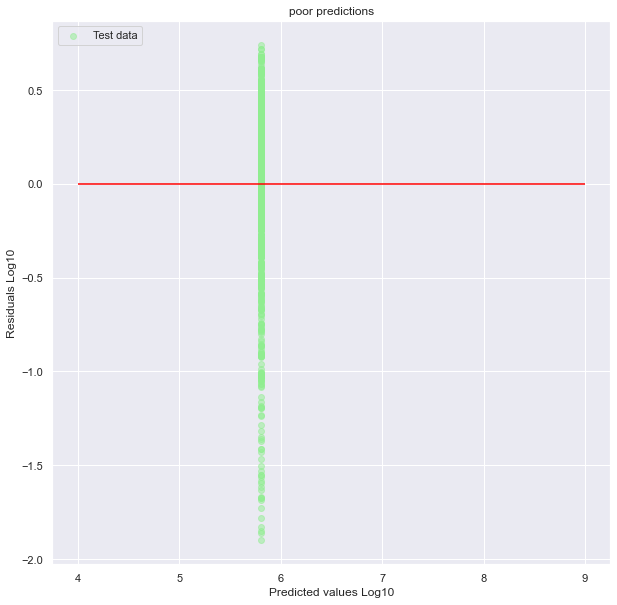

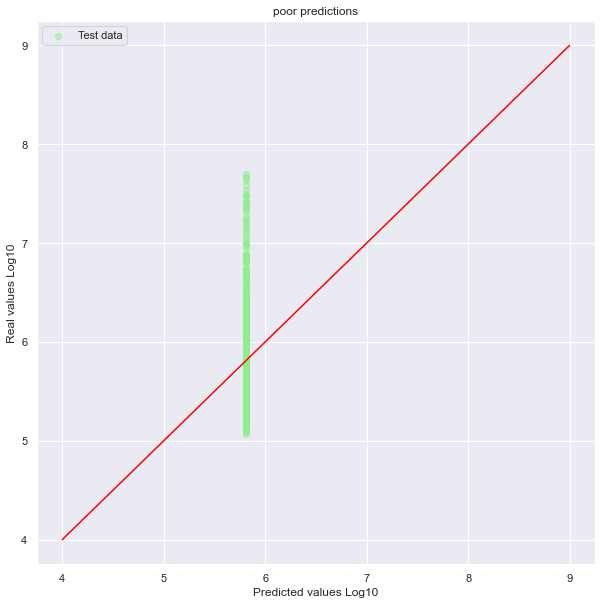

In [15]:
mean_value_vector = np.full(len(Y_test), Y_train.mean())

# Plot residuals
plt.figure(figsize=(10, 10))
#plt.scatter(Y_train_pred, Y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = "Training data")
plt.scatter(mean_value_vector, mean_value_vector - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = "Test data")
plt.title("poor predictions")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals Log10")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
#plt.scatter(Y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = "Training data")
plt.scatter(mean_value_vector, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = "Test data")
plt.title("poor predictions")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values Log10")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

## Linear regression

Starting with a simple linear regression model from sklearn

In [16]:
# create model
linear_regressor= LinearRegression()

In [17]:
# computing cross validation scores
linear_regression_scores = rmse_cv(linear_regressor,random_state, n_folds, X_train, Y_train)

print("simple linear regression : RMSE = {} with a standard deviation of {}".format(linear_regression_scores.mean(), linear_regression_scores.std()))

simple linear regression : RMSE = 0.2217455062185251 with a standard deviation of 0.008885202050338882


In [18]:
# fit the model and predict values from train an validation sets
linear_regressor.fit(X_train, Y_train)
Y_train_pred = linear_regressor.predict(X_train)
Y_test_pred = linear_regressor.predict(X_test)

In [19]:
# score full train set
linear_rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
print('train RMSE : ', linear_rmse_train)

# score test set
linear_rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
print('test RMSE : ', linear_rmse_test)

train RMSE :  0.21966370135166727
test RMSE :  0.2115704194195862


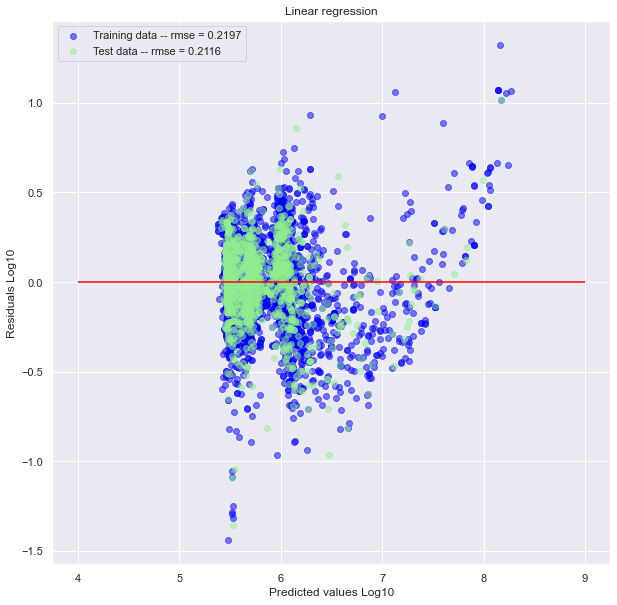

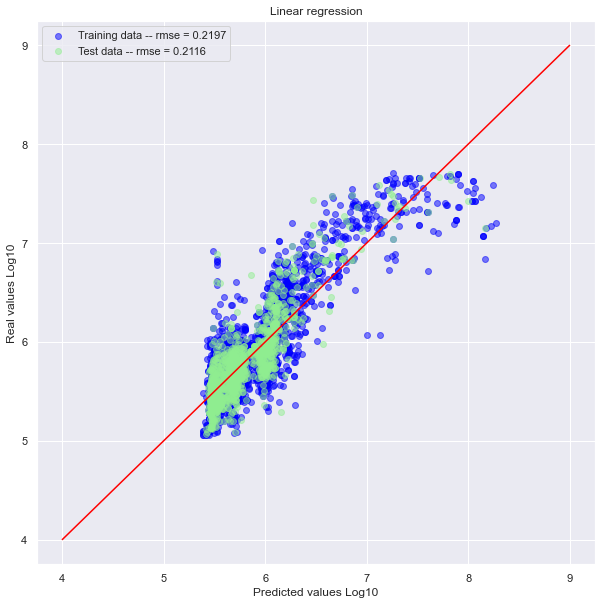

In [20]:
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = f"Training data -- rmse = {linear_rmse_train.round(4)}")
plt.scatter(Y_test_pred, Y_test_pred - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {linear_rmse_test.round(4)}")
plt.title("Linear regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals Log10")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = f"Training data -- rmse = {linear_rmse_train.round(4)}")
plt.scatter(Y_test_pred, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {linear_rmse_test.round(4)}")
plt.title("Linear regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values Log10")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

## Lasso regularization

Now we are going to use regularized linear regression models and pick the best tuning parameter thanks to the cross validation rmse function

In [21]:
# create model
lasso_regressor = Lasso(alpha =0.0001)

In [22]:
# computing cross validation scores
lasso_regression_scores = rmse_cv(lasso_regressor,random_state, n_folds, X_train, Y_train)

print("lasso linear regression : RMSE = {} with a standard deviation of {}".format(lasso_regression_scores.mean(), lasso_regression_scores.std()))

lasso linear regression : RMSE = 0.22166236500726208 with a standard deviation of 0.008889214529092283


In [23]:
# fit the model and predict values from train an validation sets
lasso_regressor.fit(X_train, Y_train)
Y_train_pred = lasso_regressor.predict(X_train)
Y_test_pred = lasso_regressor.predict(X_test)

In [24]:
# score full train set
lasso_rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
print('train RMSE : ', lasso_rmse_train)

# score test set
lasso_rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
print('test RMSE : ', lasso_rmse_test)

train RMSE :  0.21972670007126932
test RMSE :  0.21144545025054598


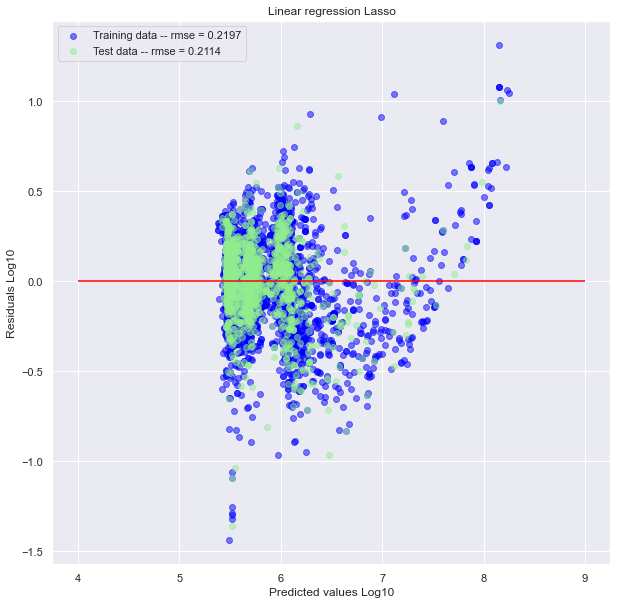

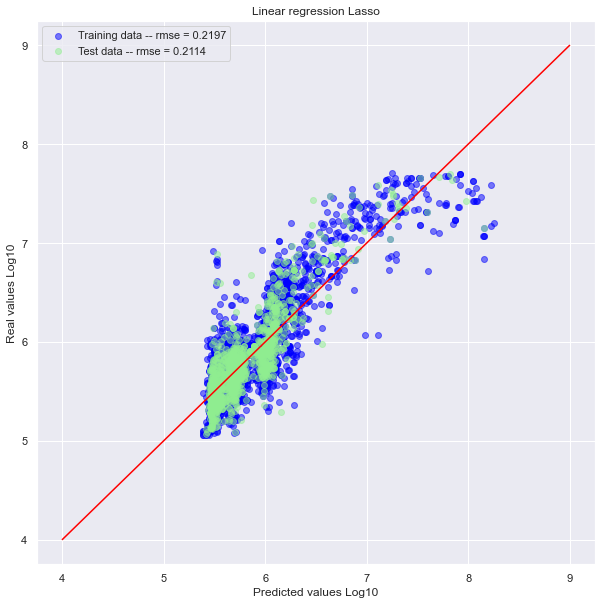

In [25]:
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = f"Training data -- rmse = {lasso_rmse_train.round(4)}")
plt.scatter(Y_test_pred, Y_test_pred - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {lasso_rmse_test.round(4)}")
plt.title("Linear regression Lasso")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals Log10")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = f"Training data -- rmse = {lasso_rmse_train.round(4)}")
plt.scatter(Y_test_pred, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {lasso_rmse_test.round(4)}")
plt.title("Linear regression Lasso")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values Log10")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

Text(0, 0.5, 'rmse')

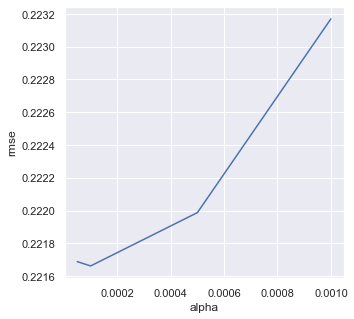

In [26]:
#[0.5, 0.1, 0.001, 0.0005, 0.0001]
alphas = [0.001, 0.0005, 0.0001, 0.00005]
cv_lasso = [rmse_cv(Lasso(alpha = alpha), random_state, n_folds, X_train, Y_train).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(figsize=(5, 5))
plt.xlabel("alpha")
plt.ylabel("rmse")

## Ridge regularization

In [27]:
# create model
ridge_regressor = Ridge(alpha =4)

In [28]:
# computing cross validation scores
ridge_regression_scores = rmse_cv(ridge_regressor, random_state, n_folds, X_train, Y_train)

print("ridge linear regression : RMSE = {} with a standard deviation of {}".format(ridge_regression_scores.mean(), ridge_regression_scores.std()))

ridge linear regression : RMSE = 0.22170525784437442 with a standard deviation of 0.008951775697443275


In [29]:
# fit the model and predict values from train an validation sets
ridge_regressor.fit(X_train, Y_train)
Y_train_pred = ridge_regressor.predict(X_train)
Y_test_pred = ridge_regressor.predict(X_test)

In [30]:
# score full train set
ridge_rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
print('train RMSE : ', ridge_rmse_train)

# score test set
ridge_rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
print('test RMSE : ', ridge_rmse_test)

train RMSE :  0.21976289076244765
test RMSE :  0.2115158857173557


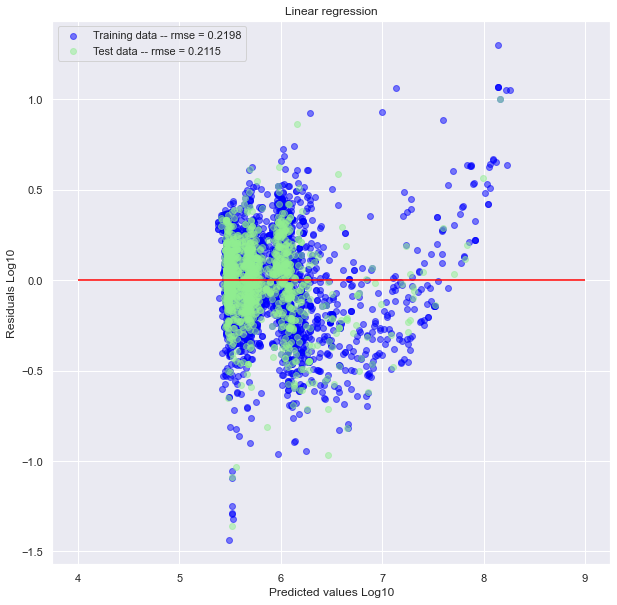

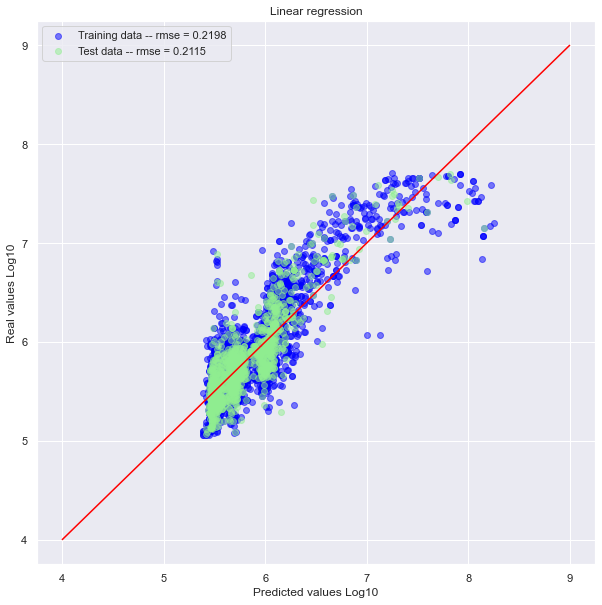

In [31]:
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = f"Training data -- rmse = {ridge_rmse_train.round(4)}")
plt.scatter(Y_test_pred, Y_test_pred - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {ridge_rmse_test.round(4)}")
plt.title("Linear regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals Log10")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = f"Training data -- rmse = {ridge_rmse_train.round(4)}")
plt.scatter(Y_test_pred, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {ridge_rmse_test.round(4)}")
plt.title("Linear regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values Log10")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

Text(0, 0.5, 'rmse')

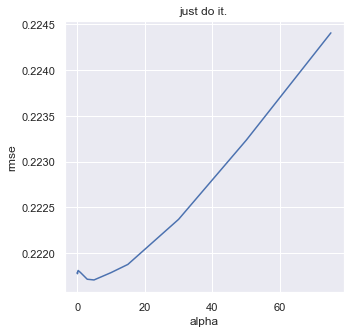

In [32]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha), random_state, n_folds, X_train, Y_train).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(figsize=(5, 5))
plt.title('just do it.')
plt.xlabel("alpha")
plt.ylabel("rmse")

## Random forest regressor

We try a basic random forest regression, then look to find a better performing choice of parameters by using the GridSearchCV sklearn method

Random Forest is a bagging ensemble method (bootstrap + aggregating) that contains a number of decision trees on various subsets of the given dataset and takes the average to improve the predictive accuracy of that dataset. Instead of relying on one decision tree, the random forest takes the prediction from each tree and based on the majority votes of predictions, and it predicts the final output. The greater number of trees in the forest leads to higher accuracy and prevents the problem of overfitting.

In [62]:
# create model
random_forest_regressor = RandomForestRegressor(
    n_estimators= 50,
    max_depth= 25,
    min_samples_split= 4,
    min_samples_leaf= 1,
    random_state= 0
)

In [63]:
# computing cross validation scores
random_forest_regression_scores = rmse_cv(random_forest_regressor,random_state, n_folds, X_train, Y_train)

print(random_forest_regression_scores)

print("random forest regression : RMSE = {} with a standard deviation of {}".format(random_forest_regression_scores.mean(), random_forest_regression_scores.std()))

[0.1559213  0.15613049 0.17281779 0.16098224 0.16142466]
random forest regression : RMSE = 0.16145529508430528 with a standard deviation of 0.006136930064656574


In [64]:
# fit the model with the full train set and predict values for full train an test sets
random_forest_regressor.fit(X_train, Y_train)
Y_train_pred = random_forest_regressor.predict(X_train)
Y_test_pred = random_forest_regressor.predict(X_test)

In [65]:
# score full train set
random_forest_rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
print('train RMSE : ', random_forest_rmse_train)

# score test set
random_forest_rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
print('test RMSE : ', random_forest_rmse_test)

train RMSE :  0.070416976475942
test RMSE :  0.14890354026403985


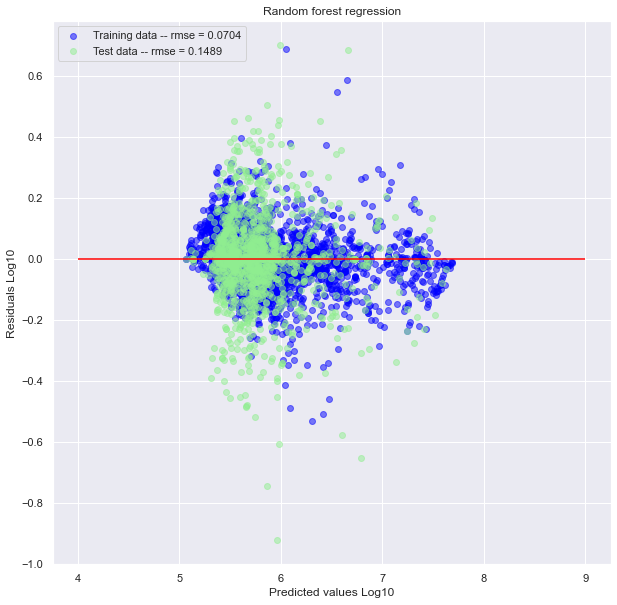

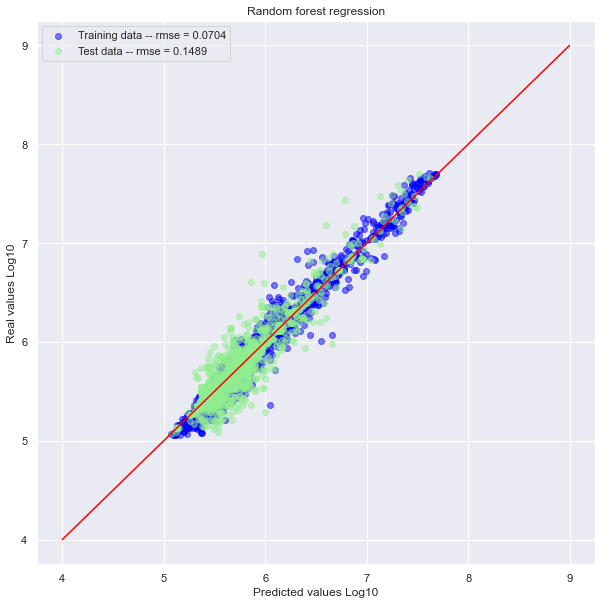

In [66]:
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = f"Training data -- rmse = {random_forest_rmse_train.round(4)}")
plt.scatter(Y_test_pred, Y_test_pred - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {random_forest_rmse_test.round(4)}")
plt.title("Random forest regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals Log10")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = f"Training data -- rmse = {random_forest_rmse_train.round(4)}")
plt.scatter(Y_test_pred, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {random_forest_rmse_test.round(4)}")
plt.title("Random forest regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values Log10")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

In [40]:
###### Training with hyperparameters optimization #######

# ⚠ code execution time ~ 30min

# Perform grid search
print("Grid search...")
regressor = RandomForestRegressor()

# Grid of values to be tested
params = {
    'max_depth': [10, 25, 100],
    'min_samples_leaf': [1, 2, 10],
    'min_samples_split': [4, 8, 12],
    'n_estimators': [50, 100, 300]
}

gridsearch = GridSearchCV(regressor, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...


KeyboardInterrupt: 

In [67]:
# create model
random_forest_regressor = RandomForestRegressor(
    n_estimators= 300,
    max_depth= 25,
    min_samples_split= 4,
    min_samples_leaf= 1, 
    random_state= 0
)

In [68]:
# computing cross validation scores
random_forest_regression_scores = rmse_cv(random_forest_regressor,random_state, n_folds, X_train, Y_train)

print(random_forest_regression_scores)

print("random forest regression : RMSE = {} with a standard deviation of {}".format(random_forest_regression_scores.mean(), random_forest_regression_scores.std()))

[0.15614972 0.15407099 0.17125975 0.16002623 0.16029564]
random forest regression : RMSE = 0.160360467512008 with a standard deviation of 0.005936298146211061


In [69]:
# fit the model with the full train set and predict values for full train an test sets
random_forest_regressor.fit(X_train, Y_train)
Y_train_pred = random_forest_regressor.predict(X_train)
Y_test_pred = random_forest_regressor.predict(X_test)

In [70]:
# score full train set
random_forest_rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
print('train RMSE : ', random_forest_rmse_train)

# score test set
random_forest_rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
print('test RMSE : ', random_forest_rmse_test)

train RMSE :  0.06925535410764506
test RMSE :  0.14817837379161564


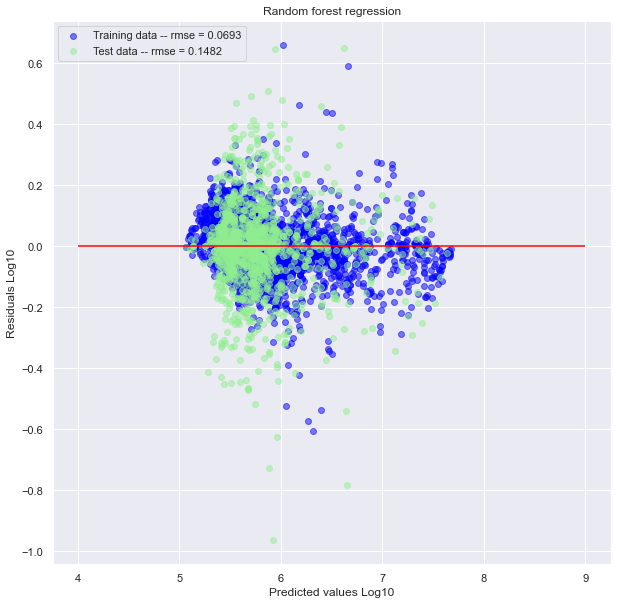

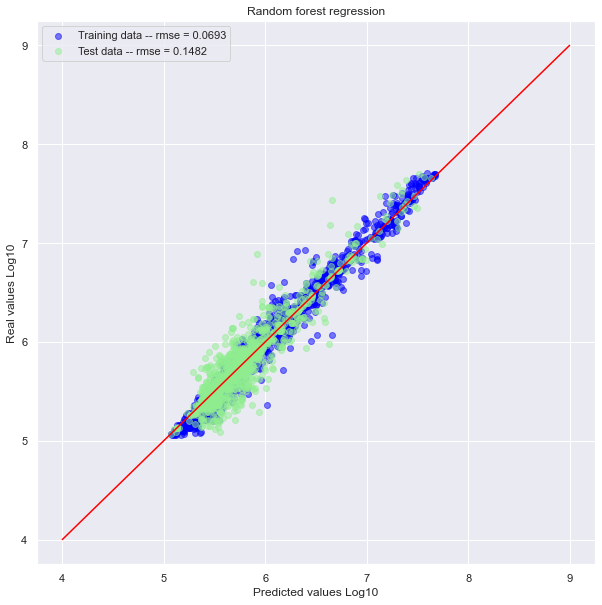

In [71]:
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = f"Training data -- rmse = {random_forest_rmse_train.round(4)}")
plt.scatter(Y_test_pred, Y_test_pred - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {random_forest_rmse_test.round(4)}")
plt.title("Random forest regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals Log10")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = f"Training data -- rmse = {random_forest_rmse_train.round(4)}")
plt.scatter(Y_test_pred, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {random_forest_rmse_test.round(4)}")
plt.title("Random forest regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values Log10")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

Text(0.5, 0, 'Random forest feature importance')

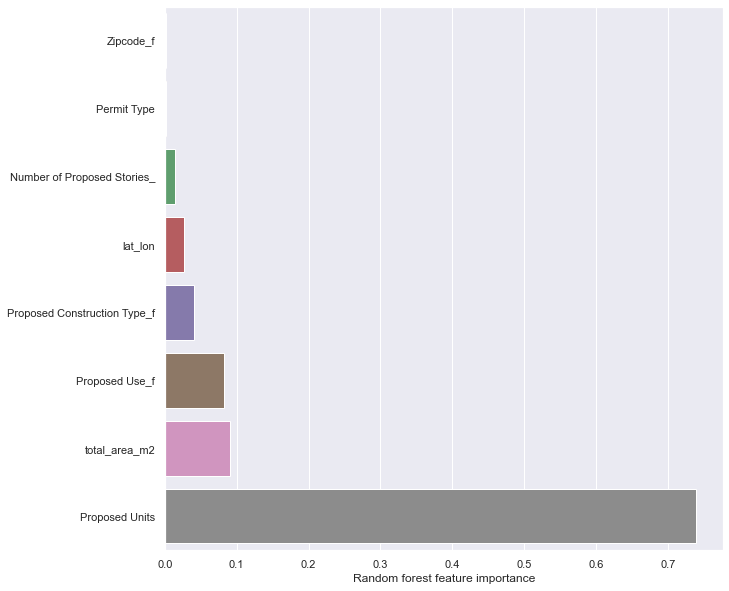

In [72]:
# plot feature importance
# The importance score is a measure of how often the feature was selected for splitting
# and how much gain in purity was achieved as a result of the selection
sorted_idx = random_forest_regressor.feature_importances_.argsort()
plt.figure(figsize=(10, 10))
sns.barplot(y = X.columns[sorted_idx], x = random_forest_regressor.feature_importances_[sorted_idx])
plt.xlabel("Random forest feature importance")

## XGBoost

 XGBoost is a boosting ensemble method that also use decision trees and bootstrapping but builds sequentialy several models while taking into account prediction errors as it goes, and then combining the different models. Boosting is a type of ensemble learning that uses the previous model's result as an input to the next one. Instead of training models separately, boosting trains models sequentially, each new model being trained to correct the errors of the previous ones. At each iteration (round), the outcomes predicted correctly are given a lower weight, and the ones wrongly predicted a higher weight. It then uses a weighted average to produce a final outcome.

In [162]:
# create model
xgb_regressor = xgb.XGBRegressor(
    max_depth=10,
    learning_rate=0.1,
    n_estimators=100,
    colsample_bytree=0.8,
    subsample=0.7,
    random_state =0
    )

In [163]:
# computing cross validation scores
xgb_regression_scores = rmse_cv(xgb_regressor,random_state, n_folds, X_train, Y_train)

print(xgb_regression_scores)

print("XGBoost regression : RMSE = {} with a standard deviation of {}".format(xgb_regression_scores.mean(), xgb_regression_scores.std()))

[0.1547165  0.15566079 0.1710695  0.16098027 0.16372889]
XGBoost regression : RMSE = 0.16123118871233444 with a standard deviation of 0.005942464276838286


In [164]:
# fit the model with the full train set and predict values for full train an test sets
xgb_regressor.fit(X_train, Y_train)
Y_train_pred = xgb_regressor.predict(X_train)
Y_test_pred = xgb_regressor.predict(X_test)

In [165]:
# score full train set
xgb_rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
print('train RMSE : ', xgb_rmse_train)

# score test set
xgb_rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
print('test RMSE : ', xgb_rmse_test)

train RMSE :  0.0877023864136958
test RMSE :  0.14850156047252244


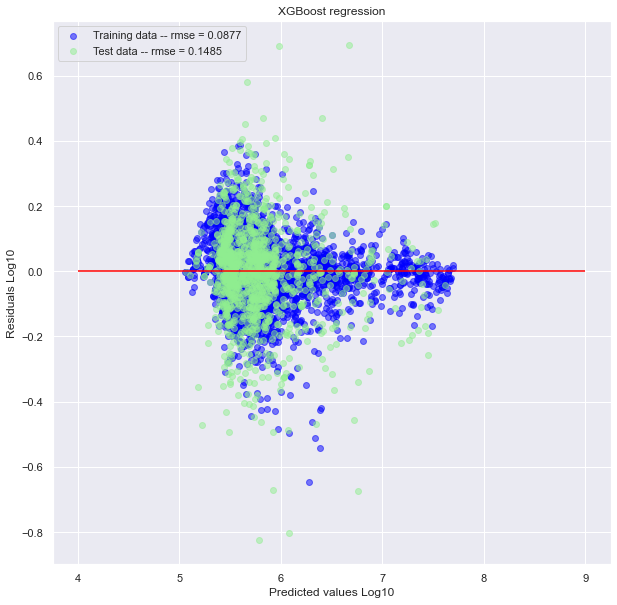

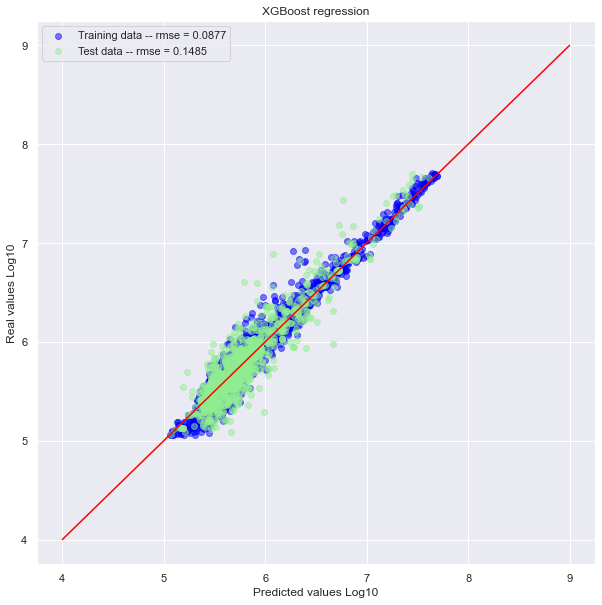

In [166]:
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = f"Training data -- rmse = {xgb_rmse_train.round(4)}")
plt.scatter(Y_test_pred, Y_test_pred - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {xgb_rmse_test.round(4)}")
plt.title("XGBoost regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals Log10")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = f"Training data -- rmse = {xgb_rmse_train.round(4)}")
plt.scatter(Y_test_pred, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {xgb_rmse_test.round(4)}")
plt.title("XGBoost regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values Log10")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

Text(0.5, 0, 'XGBoost Feature Importance')

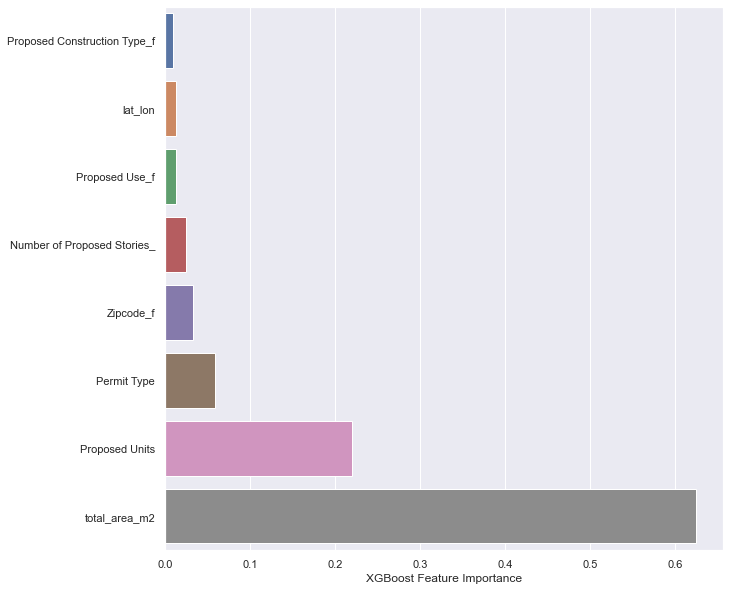

In [167]:
# plot feature importance
# The importance score is a measure of how often the feature was selected for splitting
# and how much gain in purity was achieved as a result of the selection
sorted_idx = xgb_regressor.feature_importances_.argsort()
plt.figure(figsize=(10, 10))
sns.barplot(y = X.columns[sorted_idx], x = xgb_regressor.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")

In [85]:
###### Training with hyperparameters optimization #######

# Perform grid search
print("Grid search...")
regressor = xgb.XGBRegressor()

# Grid of values to be tested

params = {
    'max_depth': [3, 5, 10],
    'learning_rate': [0.05, 0.1, 0.3],
    'n_estimators': [100, 250, 500],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'subsample': [0.7, 0.8, 0.9],
}

gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 250, 'subsample': 0.8}
Best validation accuracy :  0.8727260141548171


In [150]:
# create model
xgb_regressor = xgb.XGBRegressor(
    max_depth=10,
    learning_rate=0.05,
    n_estimators=250,
    colsample_bytree=0.9,
    subsample=0.8,
    random_state =0
    )

In [151]:
# computing cross validation scores
xgb_regression_scores = rmse_cv(xgb_regressor,random_state, n_folds, X_train, Y_train)

print(xgb_regression_scores)

print("XGBoost regression : RMSE = {} with a standard deviation of {}".format(xgb_regression_scores.mean(), xgb_regression_scores.std()))

[0.15424888 0.15251158 0.16969985 0.15991138 0.16269147]
XGBoost regression : RMSE = 0.15981263109932412 with a standard deviation of 0.006169526586800444


In [152]:
# fit the model with the full train set and predict values for full train an test sets
xgb_regressor.fit(X_train, Y_train)
Y_train_pred = xgb_regressor.predict(X_train)
Y_test_pred = xgb_regressor.predict(X_test)

In [153]:
# score full train set
xgb_rmse_train = mean_squared_error(Y_train, Y_train_pred, squared=False)
print('train RMSE : ', xgb_rmse_train)

# score test set
xgb_rmse_test = mean_squared_error(Y_test, Y_test_pred, squared=False)
print('test RMSE : ', xgb_rmse_test)

train RMSE :  0.0711701513966827
test RMSE :  0.14622500702372146


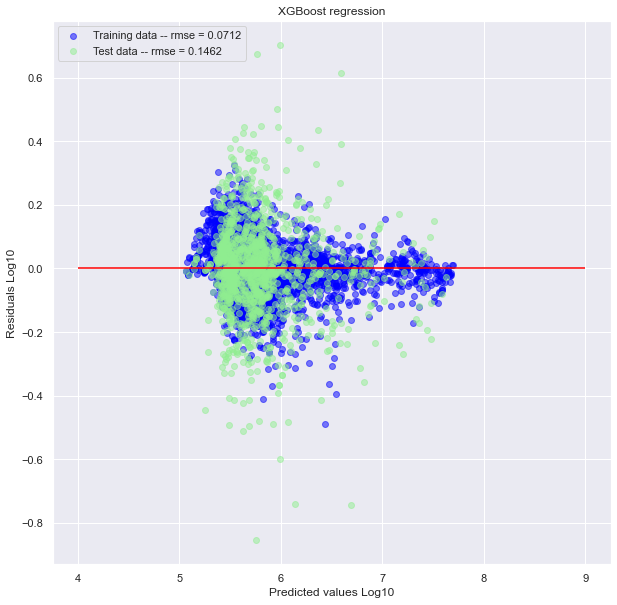

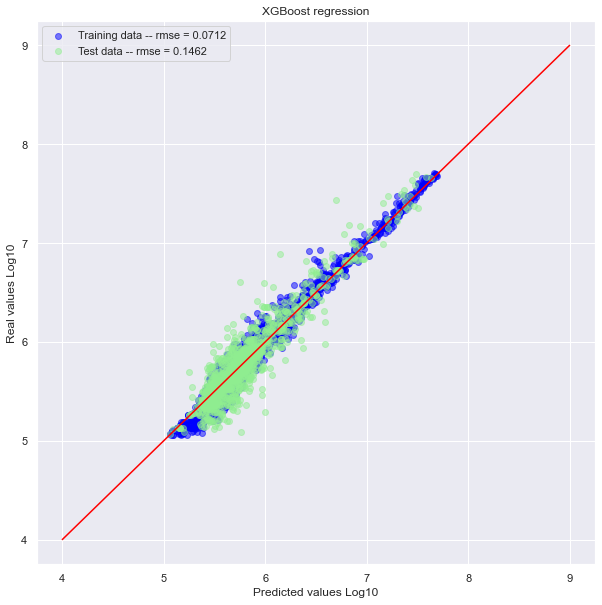

In [154]:
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train_pred - Y_train, c = "blue", marker = "o", alpha=0.5, label = f"Training data -- rmse = {xgb_rmse_train.round(4)}")
plt.scatter(Y_test_pred, Y_test_pred - Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {xgb_rmse_test.round(4)}")
plt.title("XGBoost regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Residuals Log10")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 4, xmax = 9, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred, Y_train, c = "blue", marker = "o", alpha=0.5,  label = f"Training data -- rmse = {xgb_rmse_train.round(4)}")
plt.scatter(Y_test_pred, Y_test, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {xgb_rmse_test.round(4)}")
plt.title("XGBoost regression")
plt.xlabel("Predicted values Log10")
plt.ylabel("Real values Log10")
plt.legend(loc = "upper left")
plt.plot([4, 9], [4, 9], c = "red")
plt.show()

Text(0.5, 0, 'XGBoost Feature Importance')

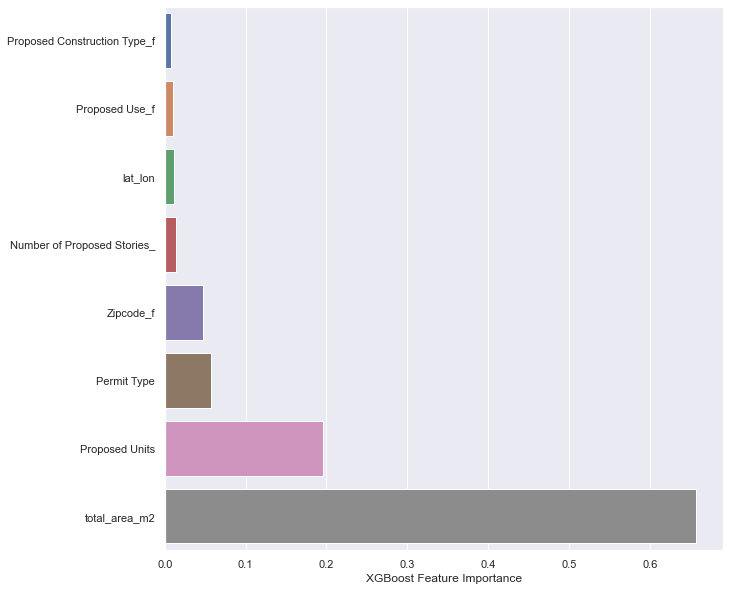

In [142]:
# plot feature importance
# The importance score is a measure of how often the feature was selected for splitting
# and how much gain in purity was achieved as a result of the selection
sorted_idx = xgb_regressor.feature_importances_.argsort()
plt.figure(figsize=(10, 10))
sns.barplot(y = X.columns[sorted_idx], x = xgb_regressor.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")

In [157]:
def raise_power_10(num):
    return 10**num

In [158]:
Y_train_dollars = np.array(list(map(raise_power_10, Y_train)))
Y_test_dollars = np.array(list(map(raise_power_10, Y_test)))
Y_train_pred_dollars = np.array(list(map(raise_power_10, Y_train_pred)))
Y_test_pred_dollars = np.array(list(map(raise_power_10, Y_test_pred)))

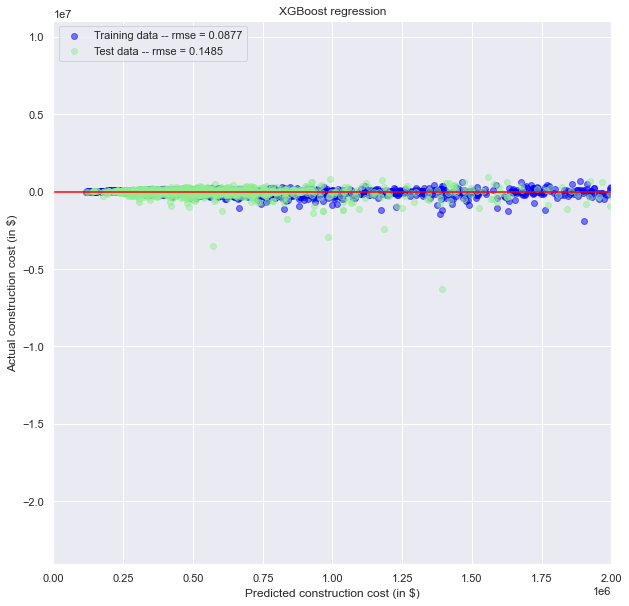

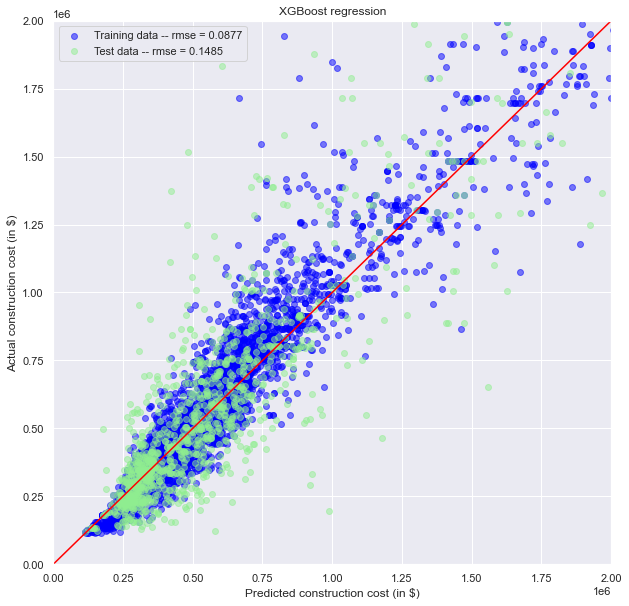

In [178]:
# Plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred_dollars, Y_train_pred_dollars - Y_train_dollars, c = "blue", marker = "o", alpha=0.5, label = f"Training data -- rmse = {xgb_rmse_train.round(4)}")
plt.scatter(Y_test_pred_dollars, Y_test_pred_dollars - Y_test_dollars, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {xgb_rmse_test.round(4)}")
plt.title("XGBoost regression")
plt.xlabel("Predicted construction cost (in $)")
plt.ylabel("Actual construction cost (in $)")
plt.xlim(0, 0.2*10**7)
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 0, xmax = 0.2*10**7, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(10, 10))
plt.scatter(Y_train_pred_dollars, Y_train_dollars, c = "blue", marker = "o", alpha=0.5,  label = f"Training data -- rmse = {xgb_rmse_train.round(4)}")
plt.scatter(Y_test_pred_dollars, Y_test_dollars, c = "lightgreen", marker = "o", alpha=0.5, label = f"Test data -- rmse = {xgb_rmse_test.round(4)}")
plt.title("XGBoost regression")
plt.xlabel("Predicted construction cost (in $)")
plt.ylabel("Actual construction cost (in $)")
plt.xlim(0, 0.2*10**7)
plt.ylim(0, 0.2*10**7)
plt.legend(loc = "upper left")
plt.plot([0, 0.2*10**7], [0, 0.2*10**7], c = "red")
plt.show()

## Save models

In [ ]:
# Save Model Using joblib


# save the model to disk
filename_model = '../Docker/finalmodel.joblib'
joblib.dump(, filename_model)

#save preprocessor to disk
filename_preprocessor = '../Docker/finalprepro.joblib'
joblib.dump(preprocessor, filename_preprocessor)

 
# some time later...
 
# load the model from disk
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, Y_test)
# print(result)

['finalprepro.jolib']